<a href="https://colab.research.google.com/github/Nastya880/cuda/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №2**

**Основы работы с технологией CUDA. Иерархия памяти в CUDA. Работа с разделяемой памятью**

**Контрольные вопросы**

1.	Какие типы памяти поддерживаются в CUDA?


```
- Регистры (Каждый потоковый мультипроцессор содержит 8192 или 16384 32-битовых регистра.На этапе компиляции они распределяются между тредами блока, тем самым влияя на количество исполняемых блоков одним мультипроцессором);
- Локальная память (это область в глобальной памяти (DRAM), выделенная компилятором для хранения локальных значений потоков. Локальная память используется для хранения локальных данных потоков в случае нехватки регистров или объявления локальных массивов внутри ядра без ключевого слова __shared__);
- Разделяемая память (расположена непосредственно в мультипроцессоре, но она выделяется на уровне блоков – каждый блок получает в свое распоряжение одно и то же количество разделяемой памяти. Всего каждый мультипроцессор содержит 16Кбайт разделяемой памяти, и от того, сколько разделяемой памяти требуется блоку, зависит количество блоков, которое может быть запущено на одном мультипроцессоре. Доступна всем тредам на чтение и запись);
- Глобальная память (это обычная DRAM-память, которая выделяется при помощи специальных функций на СPU. Все треды сетки могут читать и писать в глобальную память);
- Текстурная память;
- Константная память (используется, когда в ядро необходимо передать много различных данных, которые будут одинаково использоваться всеми тредами ядра. Использование внутри ядра ничем не отличается от использования обычной глобальной переменной на хосте).
```

2.	В чем заключается эффективность работы с глобальной и разделяемой памятью в CUDA?
```
Глобальная память – это память DRAM, которая выделяется с помощью специальных функций на CPU. Она обладает высокой латентностью (400-800 тактов). Правильное использование глобальной памяти является одним из направлений оптимизации программы. Глобальная память является основным местом для размещения и хранения большого объема данных для обработки ядрами. Глобальная память выделяется и освобождается CPU.
Разделяемая память. Каждый потоковый мультипроцессор содержит 16 Кбайт разделяемой памяти. Она поровну делится между всеми блоками сетки, исполняемыми на мультипроцессоре.
Стандартная схема работы с разделяемой памятью выглядит следующим образом:
• загрузить необходимые данные в разделяемую память(из глобальной),
• __syncthreads(),
• выполнить вычисления с загруженными данными,
• __syncthreads(),
• записать результат в глобальную память.
```

3.	Какие паттерны доступа к глобальной памяти существуют?
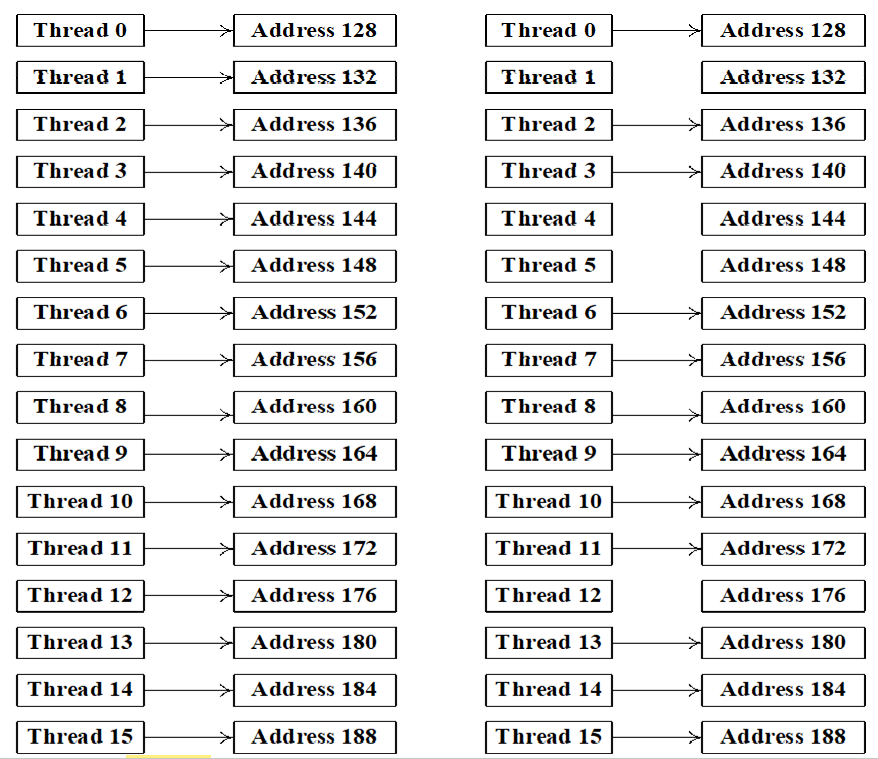

4.	Какие паттерны доступа к разделяемой памяти существуют?
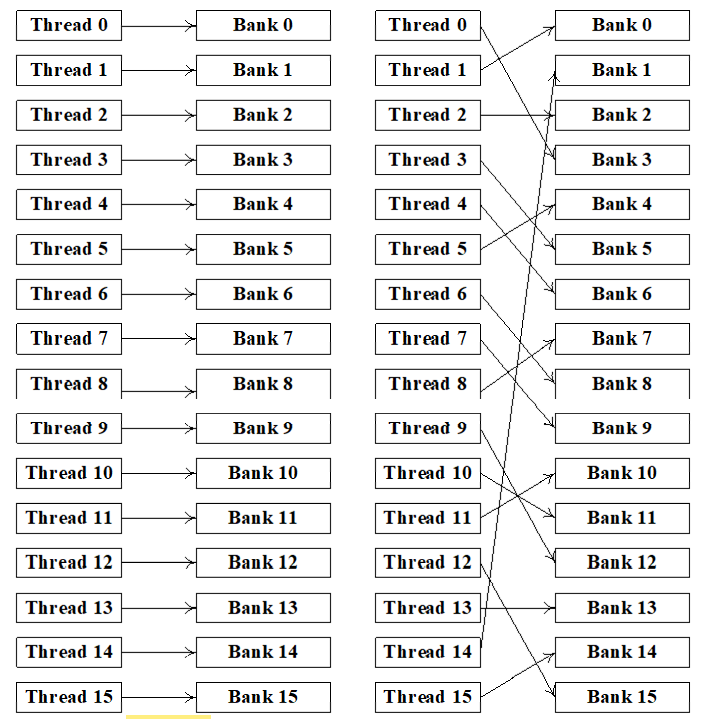


5.	В чем особенность схемы расположения банков в разделяемой памяти?
```
Банки строятся из 32-битовых слов (рисунок 2.7). Подряд идущие 32-битовые слова попадают в подряд идущие банки. Конфликт доступа к банкам (bank conflict) возникает, если несколько нитей из одного half-warp’а (CUDA 1.x) или из одного warp’а (CUDA 2.x/3.x)  обращаются к одному и тому же банку. Конфликта не происходит, если все 16 нитей обращаются к одному слову.
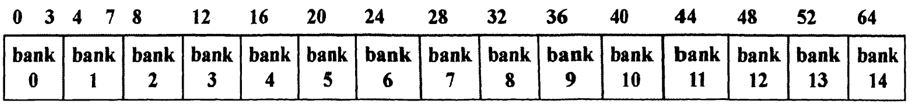
``` 
6.	Каким образом можно определить объем разделяемой памяти?
```
Разделяемая (shared) память расположена непосредственно в потоковом мультипроцессоре. Каждый потоковый мультипроцессор содержит 16 Кбайт разделяемой памяти. Каждый блок получает в свое распоряжение одно и то же количество разделяемой памяти. Объем памяти зависит от количества блоков.
```
7.	Как определить номер банка памяти?
```
Номер банка можно определить согласно следующим выражениям:
Номер банка = (Адрес в байтах/4)%32 — для устройства версии 2.0.
Номер банка = (Адрес в байтах/4)%16 — для устройства версии 1.x.
```
8.	Основные принципы оптимизации работы с памятью в CUDA.
```
-	использование выравнивания;
-	максимальное использование разделяемой памяти;
-	объединение нескольких запросов к глобальной памяти в один (coalescing);
-	использование специальных паттернов доступа к памяти, гарантирующих эффективный доступ. Паттерны работают независимо в пределах каждого half-warp’а.
Объединение (coalescing) для GPU с Compute Capability 1.0/1.1 случается в следующих случаях: 
-	нити обращаются к 32-битовым словам, давая 64-байтовый блок,  или к 64-битовым словам, давая 128-байтовый блок;
-	все 16 слов лежат в пределах блока;
-	k-ая нить half-warp’а обращается к k-му слову блока.

```
9.	Общий шаблон решения задач в CUDA. 
```
1. Выделение набора инструкций исполняемых одним экземпляром ядра. 
2. Выделение набора данных, общего для блока ядер и загрузка его в разделяемую память. 
3. Если объемы данных на шаге 2 слишком велики или набор инструкций выделенных на шаге 1 предполагает слишком интенсивные вычисления задача декомпозируется на более простые задачи. 
4. Производятся вычисления над подгруженными ранее данными. 
5. Результаты вычисления копируются назад, в глобальную память. 
Особое внимание следует уделять размерностям блоков и сетки. Так, если ядра содержат большое количество инструкций – стоит уменьшить размерность блоков. Это позволит более эффективно использовать регистровую память GPU.

```

Настройка для запуска CUDA

In [1]:
!git config --global url."https://github.com/".insteadOf git://github.com/
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-s7as8se0
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-s7as8se0
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=0fc1228fb4674f716e2fb67bbd8bebe7823f6856dba39dbb0b1eff011a6cee40
  Stored in directory: /tmp/pip-ephem-wheel-cache-0c5o290o/wheels/69/4f/dd/2613eddd1a84d8809a21caa3a45ccaae9eac9279231c2feabc
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [2]:
!sudo ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc
!sudo ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++

In [3]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


# CUDA НАСТРОЕНА!

**Задание 1. Даны два вектора А и В из N натуральных (ненулевых) элементов (задаются случайно). Вектора расположены в глобальной памяти. Написать программу на Cи с использованием CUDA runtime API, выполняющую поэлементное умножение двух векторов на GPU так, чтобы продемонстрировать паттерны доступа к глобальной памяти, приводящие и не приводящие к объединению запросов в одну транзакцию.
Измерить время работы программ. Написать программу для верификации результатов. Результаты занести в отчёт.**

*CUDA API для CPU (host) выступает в двух формах - низкоуровневый CUDA driver API и CUDA runtime API (реализованный через CUDA driver API).
Многие функции API являются асинхронными, т.е. управление возвращается еще до реального завершения требуемой операции.*

*К числу асинхронных операций относятся:*

*-запуск ядра*

*-функции копирования памяти, имена которых оканчиваются на Async*

*-функции копирования памяти device <-> device*

*-функции инициализации памяти.*

**Пример работы векторного скалярного произведения
(x1,x2,x3,x4)·(y1,y2,y3,y4) = x1y1+x2y2+x3y3+x4y4**

In [ ]:
%%writefile standartMultVector.cu
#include <iostream>

const int  N = 33 * 1024;
//const int  N = 33;

int main()
{
	int *a, *b, c;
	a = (int*)malloc(N * sizeof(int));
	b = (int*)malloc(N * sizeof(int));
	for (int i = 0; i < N; i++) {
		a[i] = i;
		b[i] = i * 2;
	}
	c = 0;
	for (int i = 0; i < N; i++) {
		c += a[i] * b[i];
	}

	printf("Result = %d\n", c);
  return 0;
}

Overwriting standartMultVector.cu


In [ ]:
!nvcc standartMultVector.cu -o standartMultVector -Wno-deprecated-gpu-targets
!nvprof ./standartMultVector

======== Warning: CUDA device error, GPU profiling skipped
Result = 1005595648
======== Warning: No profile data collected.


In [76]:
%%writefile multVector.cu
#include <iostream>
#include <cuda.h>
#include <cuda_runtime.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>
#include <chrono>
#include <vector>



void multiVectorHost(int* A, int* B, int* C, const int size) {
	for (int i = 0; i < size; ++i) {
		C[i] = A[i] * B[i];
	}
}

void fillArray(int* array, int size) {
	time_t t;
	srand((unsigned)time(&t));
	for (int i = 0; i < size; ++i) {
		array[i] = rand() % 10;
	}
}

__global__ void multiVectorGPU(int* MatA, int* MatB, int* MatC, int size, int shift)
{
	unsigned int ix = (threadIdx.x + blockIdx.x * blockDim.x + shift) % size;

	if (ix < size)
		MatC[ix] = MatA[ix] * MatB[ix];
}

void checkResult(int* hostRef, int* gpuRef, const int N)
{
	for (int i = 0; i < N; ++i)
	{
		if (hostRef[i] != gpuRef[i])
		{
			printf("ERROR %d %d", hostRef[i], gpuRef[i]);
			break;
		}
	}
}

int main()
{
	int size = 1  << 26;

	int* h_A, * h_B, * hostRef, * gpuRef;
	h_A = (int*)malloc(size * sizeof(int));
	h_B = (int*)malloc(size * sizeof(int));
	hostRef = (int*)malloc(size * sizeof(int));
	gpuRef = (int*)malloc(size * sizeof(int));

	cudaEvent_t start, stop;
	float gpuTime = 0.0f;

	cudaEventCreate(&start);
	cudaEventCreate(&stop);

	fillArray(h_A, size);
	fillArray(h_B, size);

	int* d_MatA, * d_MatB, * d_MatC;
	cudaMalloc((void**)&d_MatA, size * sizeof(int));
	cudaMalloc((void**)&d_MatB, size * sizeof(int));
	cudaMalloc((void**)&d_MatC, size * sizeof(int));
	cudaMemcpy(d_MatA, h_A, size * sizeof(int), cudaMemcpyHostToDevice);
	cudaMemcpy(d_MatB, h_B, size * sizeof(int), cudaMemcpyHostToDevice);

	auto t1 = std::chrono::high_resolution_clock::now();
	multiVectorHost(h_A, h_B, hostRef, size);
	auto t2 = std::chrono::high_resolution_clock::now();

	auto duration = std::chrono::duration_cast<std::chrono::milliseconds>(t2 - t1).count();
	printf("Multiplication of the vector on host %lu ms\n", duration);

	int thread = 1024;
	int block = size / thread;
printf("sdfgh%d", block);
	cudaEventRecord(start, 0);
	multiVectorGPU <<<block, thread>>> (d_MatA, d_MatB, d_MatC, size, shift);
	cudaEventRecord(stop, 0);
	cudaEventSynchronize(stop);
	cudaEventElapsedTime(&gpuTime, start, stop);

	printf("Multiplication of the vector on device (kernel<<<%d, %d>>>) %f ms\n", block, thread, gpuTime);
	cudaMemcpy(gpuRef, d_MatC, size * sizeof(int), cudaMemcpyDeviceToHost);
	checkResult(hostRef, gpuRef, size);

	cudaEventDestroy(start);
	cudaEventDestroy(stop);

	cudaFree(d_MatA);
	cudaFree(d_MatB);
	cudaFree(d_MatC);

		free(h_A);
		free(h_B);
		free(hostRef);
		free(gpuRef);
	
	return 0;
}



Overwriting multVector.cu


In [77]:
!nvcc multVector.cu -o multVector1 -Wno-deprecated-gpu-targets
!nvprof ./multVector1

multVector.cu(84): error: identifier "shift" is undefined

1 error detected in the compilation of "multVector.cu".
======== Warning: CUDA device error, GPU profiling skipped
size is 512 bytes
Multiplication of the vector on host took 0 ms
Multiplication of the vector on device (kernel<<<0, 1024>>>) 0.000000 ms
ERROR 25 -1278345216======== Warning: No profile data collected.


**Задание 2. Написать программу на Cи с использованием CUDA runtime API в соответствии с вариантом задания. Измерить время работы программы для различных значений параметров на CPU, GPU с использованием глобально памяти, GPU с использованием разделяемой памяти. Написать программу для верификации результатов. Результаты занести в отчёт.**

**Дана матрица А из NxN натуральных (ненулевых) элементов (задаются случайно). Матрица расположена в глобальной памяти.
Написать программу, выполняющую транспонирование матрицы в двумерной сетке.**

In [79]:
%%writefile trMatrix.cu
#include <iostream>
#include <cuda.h>
#include <cuda_runtime.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>
#include <chrono>
#include <vector>

constexpr int TILE_DIM = 32;
constexpr int BLOCK_ROWS = 8;

#define ABS(a) ((a) > 0 ? (a) : -(a))


void trMatrixOnHost(float* A, float* C, const int nx, const int ny) {
	float* ia = A;
	float* ic = C;

	for (int iy = 0; iy < ny; iy++) {
		for (int ix = 0; ix < nx; ix++) {
			ic[ix * nx + iy] = ia[iy * ny + ix];
		}
	}
}

void fillArray(float* array, int size) {
	time_t t;
	srand((unsigned)time(&t));
	for (int i = 0; i < size; ++i) {
		array[i] = (float)(rand() % 1000) / 1000.0f;
	}
}

__global__ void trMatrixOnGPU2D(float* odata, const float* idata)
{
	int x = blockIdx.x * TILE_DIM + threadIdx.x;
	int y = blockIdx.y * TILE_DIM + threadIdx.y;
	int width = gridDim.x * TILE_DIM;

	for (int j = 0; j < TILE_DIM; j += BLOCK_ROWS)
	{
		odata[x * width + (y + j)] = idata[(y + j) * width + x];
	}
}

__global__ void trMatrixOnGPU2DShared(float* odata, const float* idata)
{
	__shared__ float tile[TILE_DIM][TILE_DIM];

	int x = blockIdx.x * TILE_DIM + threadIdx.x;
	int y = blockIdx.y * TILE_DIM + threadIdx.y;
	int width = gridDim.x * TILE_DIM;

	for (int j = 0; j < TILE_DIM; j += BLOCK_ROWS)
		tile[threadIdx.y + j][threadIdx.x] = idata[(y + j) * width + x];

	__syncthreads();

	x = blockIdx.y * TILE_DIM + threadIdx.x;
	y = blockIdx.x * TILE_DIM + threadIdx.y;

	for (int j = 0; j < TILE_DIM; j += BLOCK_ROWS)
		odata[(y + j) * width + x] = tile[threadIdx.x][threadIdx.y + j];
}

void checkResult(float* hostRef, float* gpuRef, const int N)
{
	double epslion = 1.0E-8;
	bool match = true;
	
	for (int i = 0; i < N; ++i)
	{
		if (ABS(hostRef[i] - gpuRef[i]) > epslion)
		{
			match = false;
			break;
		}
	}

	std::cout << (match ? "Data are equal" : "Data aren't equal") << std::endl;

}


int main()
{

		int nx = 1 << 13;
		int ny = 1 << 13;

		int nxy = nx * ny;
		int nBytes = nxy * sizeof(float);
		printf("Matrix size is %dx%d\n", nx, ny);

		float* h_A, * hostRef, * gpuRef, * gpuReff;
		h_A = (float*)malloc(nBytes);
		hostRef = (float*)malloc(nBytes);
		gpuRef = (float*)malloc(nBytes);
		gpuReff = (float*)malloc(nBytes);

		cudaEvent_t start, stop;
		float gpuTime = 0.0f;

		cudaEventCreate(&start);
		cudaEventCreate(&stop);

		fillArray(h_A, nxy);

		float* d_MatA, * d_MatC, * d_Matq;
		cudaMalloc((void**)&d_MatA, nBytes);
		cudaMalloc((void**)&d_MatC, nBytes);
		cudaMalloc((void**)&d_Matq, nBytes);
		cudaMemcpy(d_MatA, h_A, nBytes, cudaMemcpyHostToDevice);

		dim3 grid(nx / TILE_DIM, ny / TILE_DIM, 1);
		dim3 thread(TILE_DIM, BLOCK_ROWS, 1);

		cudaEventRecord(start, 0);
		trMatrixOnGPU2D << <grid, thread >> > (d_MatC, d_MatA);
		cudaEventRecord(stop, 0);

		cudaEventSynchronize(stop);
		cudaEventElapsedTime(&gpuTime, start, stop);

		printf("Matrix transposition on gpu with <<<(%d,%d),(%d,%d)>>> took %f ms\n", grid.x, grid.y, thread.x, thread.y, gpuTime);

		cudaMemcpy(gpuRef, d_MatC, nBytes, cudaMemcpyDeviceToHost);

		auto t1 = std::chrono::high_resolution_clock::now();
		trMatrixOnHost(h_A, hostRef, nx, ny);
		auto t2 = std::chrono::high_resolution_clock::now();

		auto duration = std::chrono::duration_cast<std::chrono::milliseconds>(t2 - t1).count();
		printf("Matrix transposition on host took %lu ms\n", duration);

		checkResult(hostRef, gpuRef, nxy);


		//------------------------------------------------------------------------//
		float gpuTime1 = 0.0f;

		cudaEventRecord(start, 0);
		trMatrixOnGPU2DShared << <grid, thread >> > (d_Matq, d_MatA);
		cudaEventRecord(stop, 0);

		cudaEventSynchronize(stop);
		cudaEventElapsedTime(&gpuTime1, start, stop);

		cudaMemcpy(gpuReff, d_Matq, nBytes, cudaMemcpyDeviceToHost);
		printf("Matrix transposition on gpu with <<<(%d,%d),(%d,%d)>>> and shared memory took %f ms\n", grid.x, grid.y, thread.x, thread.y, gpuTime1);

		checkResult(hostRef, gpuReff, nxy);

		cudaEventDestroy(start);
		cudaEventDestroy(stop);

		cudaFree(d_MatA);
		cudaFree(d_MatC);

		free(h_A);
		free(hostRef);
		free(gpuRef);

	return(0);
}



Writing trMatrix.cu


In [80]:
!nvcc trMatrix.cu -o test -Wno-deprecated-gpu-targets
!nvprof ./test "24" 24

======== Warning: CUDA device error, GPU profiling skipped
Matrix size is 8192x8192
Matrix transposition on gpu with <<<(256,256),(32,8)>>> took 0.000000 ms
Matrix transposition on host took 2910 ms
Data aren't equal
Matrix transposition on gpu with <<<(256,256),(32,8)>>> and shared memory took 0.000000 ms
Data aren't equal
======== Warning: No profile data collected.
